In [18]:
import os
import random
import numpy as np
import math
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ
from qiskit.tools.visualization import plot_histogram
from dotenv import load_dotenv
# Load the API key from the .env file
load_dotenv()
IBM_TOKEN = os.getenv('IBM_TOKEN')
IBMQ.delete_account()
IBMQ.save_account(IBM_TOKEN)
IBMQ.load_account()
max_qubits = 7

# Define functions to simplify interactions with quantum computers
def get_quantum_computer(qubits=2, simulation=False, verbose=False):
    quantum_computer = None
    if qubits > max_qubits:
        print(f"No Quantum Computers available with {qubits} qubits.")
        simulation = True
    # Finds a quantum computer at IBM with the lowest queue as long as it has enough qubits for the circuit
    if simulation == False: # Execute the circuit on a quantum computer at IBM
        lowest = float('inf')
        provider = IBMQ.get_provider(hub='ibm-q')
        for backend in provider.backends():
            try:
                if "simulator" not in backend.name():
                    queue = backend.status().pending_jobs
                    qubit_count = len(backend.properties().qubits)
                    if qubit_count >= qubits:
                        if queue < lowest:
                            lowest = queue
                            quantum_computer = provider.get_backend(backend.name())
                        if verbose == True:
                            print(f"Quantum Computer {backend.name()} has {queue} queued jobs and {qubit_count} qubits")
                    else:
                        if verbose == True:
                            print(f"Quantum Computer {backend.name()} has {qubit_count} qubits, but we need {qubits} qubits")
            except:
                print(f"Quantum Computer {backend.name()} is not operational")
        if quantum_computer is None:
            print(f"No Quantum Computers available with {qubits} qubits.")
            simulation = True
    if simulation == True or quantum_computer is None: # Execute the circuit on the simulator
        quantum_computer = Aer.get_backend('qasm_simulator')
        if verbose == True:
            print(f"Using Quantum Computer Simulator")
    if verbose == True and simulation == False:
        print(f"Using Quantum Computer: {quantum_computer.name()} with {quantum_computer.status().pending_jobs} queued jobs")
    return quantum_computer

def prepare_quantum_circuit(qubits=2, classical_bits=2, simulation=False, verbose=False):
    # Create registers for the circuit
    quantum_register = QuantumRegister(qubits)
    classical_register = ClassicalRegister(classical_bits)
    # Create a Quantum Circuit
    quantum_circuit = QuantumCircuit(quantum_register, classical_register)
    # Get a quantum computer with at least the number of selected qubits for the circuit and the lowest queue, or the simulator
    quantum_computer = get_quantum_computer(qubits=qubits, simulation=simulation, verbose=verbose)
    return quantum_circuit, quantum_register, classical_register, quantum_computer

def execute_quantum_circuit(quantum_circuit, quantum_computer, shots=500, verbose=False):
    queue_position = quantum_computer.status().pending_jobs + 1
    if verbose == True:
        print(f"Your job is number {queue_position} in the queue on {quantum_computer.name()}.  Please wait...")
    result = execute(quantum_circuit, backend=quantum_computer, shots=shots).result()
    counts = result.get_counts(quantum_circuit)
    if verbose == True:
        print(f"{result.status} in {result.time_taken} seconds on {quantum_computer.name()}")
    highest_probable = result.get_counts(quantum_circuit).most_frequent()
    if verbose == True:
        probability = 100 * float(result.get_counts(quantum_circuit)[highest_probable])/float(shots)
        print(f"The probable result was {highest_probable} with {probability}% probability")
    return highest_probable, result, counts

def bell_state_circuit(quantum_circuit, quantum_register, classical_register):
    # Build a Bell State circuit
    # https://en.wikipedia.org/wiki/Bell_state
    quantum_circuit.h(quantum_register[0])
    quantum_circuit.cx(quantum_register[0], quantum_register[1])
    quantum_circuit.measure(quantum_register, classical_register)
    drawing = quantum_circuit.draw()
    return quantum_circuit, drawing

def brute_force_circuit(quantum_circuit, quantum_register, classical_register):
    # Build a brute force circuit using 3 qubits
    # https://en.wikipedia.org/wiki/Quantum_logic_gate#Quantum_logic_gates
    quantum_circuit.h(quantum_register[0])
    quantum_circuit.x(quantum_register[1])
    quantum_circuit.cx(quantum_register[0], quantum_register[1])
    quantum_circuit.h(quantum_register[2])
    quantum_circuit.cx(quantum_register[1], quantum_register[2])
    quantum_circuit.measure(quantum_register, classical_register)
    drawing = quantum_circuit.draw()
    return quantum_circuit, drawing

def iterate_words(words, shots=500, verbose=False):
    new_words = {}
    for word in words:
        quantum_circuit, quantum_register, classical_register, quantum_computer = prepare_quantum_circuit(qubits=3, classical_bits=3, simulation=True, verbose=True)
        quantum_circuit, drawing = brute_force_circuit(quantum_circuit, quantum_register, classical_register)
        highest_probable, result, counts = execute_quantum_circuit(quantum_circuit, quantum_computer, shots=shots, verbose=True)
        
        if highest_probable not in new_words:
            new_words[highest_probable] = word
        else:
            # I didn't like that answer, try again with less shots!
            if shots > 1:
                shots = int(shots/2)
            else:
                # We have exhausted our options, the gods have willed that this is not an option.
                continue
            new_words = iterate_words(words, quantum_circuit, quantum_register, classical_register, quantum_computer, shots=shots, verbose=verbose)
    return new_words

def brute_force(words, quantum_circuit, quantum_register, classical_register, quantum_computer, shots=500, verbose=False):
    # Lets do something silly.  Lets brute force a password if there are only 8 possible passwords.
    # We could wrap this in a function and pass in a dictionary then make this roll a probability for each, but we will just use a list for now.
    # There is no way this can be accurate, but it is fun to see the results.
    # Shuffle the list of words so that they're essentially in super position until observed below.
    quantum_circuit, drawing = brute_force_circuit(quantum_circuit, quantum_register, classical_register)
    highest_probable, result, counts = execute_quantum_circuit(quantum_circuit, quantum_computer, shots=shots, verbose=True)
    random.shuffle(words)
    probabilities = {}
    # This isn't working below - I need to find a way to match a word randomly to each result and then calculate the probability of each word.
    for key, value in counts.items():
        for word in words:
            if word not in probabilities.keys():
                probability = 100 * float(value)/float(shots)
                probabilities[word] = f"{probability}%"

    return probabilities, drawing, highest_probable, result, counts

def shors_circuit(N, quantum_circuit, quantum_register, classical_register, quantum_computer, shots=500, verbose=False):
    # The number we want to factorize
    N = 39
    for j in range(len(quantum_register)):
        quantum_circuit.h(quantum_register[j])
        for k in range(j + 1, len(quantum_register)):
            quantum_circuit.cp(math.pi / float(2 ** (k - j)), quantum_register[k], quantum_register[j])
        quantum_circuit.measure(quantum_register[j], classical_register[j])
    drawing = quantum_circuit.draw()
    return quantum_circuit, drawing

def factorize(N=39):
    # We want to find factors of 39, so set N to 39
    # We need to know how many bits we need to represent N
    bit_count = math.ceil(math.log(N, 2)) + 1
    # Set up the circuit
    quantum_circuit, quantum_register, classical_register, quantum_computer = prepare_quantum_circuit(qubits=bit_count, classical_bits=bit_count, simulation=False, verbose=True)
    quantum_circuit, drawing = shors_circuit(39, quantum_circuit, quantum_register, classical_register, quantum_computer)
    highest_probable, result, counts = execute_quantum_circuit(quantum_circuit, quantum_computer, shots=8192, verbose=True)
    
    return highest_probable, result, counts, drawing

def deutsch_jozsa_circuit(f, n, quantum_circuit, quantum_register, classical_register, quantum_computer):
    """
    Uses the Deutsch-Jozsa algorithm to determine whether a given Boolean function f on n qubits is
    constant (returns always 0 or always 1) or balanced (returns 0 and 1 with equal probability)
    """    
    # Prepare the input qubits in the |+> state
    for i in range(n):
        quantum_circuit.h(i)
    # Oracle that evaluates the given Boolean function f on n qubits
    for i in range(n):
        if f[i] == '1':
            quantum_circuit.x(i)
    quantum_circuit.cx(0, n)
    for i in range(n):
        if f[i] == '1':
            quantum_circuit.x(i)

    # Apply Hadamard gate again
    for i in range(n):
        quantum_circuit.h(i)
    # Measure the output
    quantum_circuit.measure(quantum_register[0], classical_register[0])
    drawing = quantum_circuit.draw()
    return quantum_circuit, drawing

def alethiometer(statement):
    # I thought it would be fun to make a quantum alethiometer.
    # https://en.wikipedia.org/wiki/Alethiometer
    # It is just a joke, but it is fun to see how it works.
    # We also don't even have enough qubits available to convert a single letter to binary, so it will only run on the simulator.
    f = ''.join(format(ord(x), 'b') for x in statement)
    n = len(f)
    qubits = n+1
    quantum_circuit, quantum_register, classical_register, quantum_computer = prepare_quantum_circuit(qubits=qubits, classical_bits=1, simulation=False, verbose=True)
    quantum_circuit, drawing = deutsch_jozsa_circuit(f, n, quantum_circuit, quantum_register, classical_register, quantum_computer)
    highest_probable, result, counts = execute_quantum_circuit(quantum_circuit, quantum_computer, shots=8192, verbose=True)
    if '0' in highest_probable:
        answer = True
    else:
        answer = False
    print(f"Your statement '{statement}' is {answer}.")
    return answer

ibmqfactory.load_account:WARNING:2023-01-11 09:05:19,041: Credentials are already in use. The existing account in the session will be replaced.


In [30]:
# Run factorization algorithm on 390
highest_probable, result, counts, drawing = factorize(390)
drawing

No Quantum Computers available with 10 qubits.
Using Quantum Computer Simulator
Your job is number 1 in the queue on qasm_simulator.  Please wait...
COMPLETED in 0.010260820388793945 seconds on qasm_simulator
The probable result was 0011011100 with 0.2197265625% probability


┌───┐                                                                 »
q118_0: ┤ H ├─■────────■─────────────■─────────────────■──────────────────────»
        └───┘ │P(π/2)  │       ┌───┐ │                 │                      »
q118_1: ──────■────────┼───────┤ H ├─┼────────■────────┼─────────■────────────»
                       │P(π/4) └───┘ │        │P(π/2)  │         │       ┌───┐»
q118_2: ───────────────■─────────────┼────────■────────┼─────────┼───────┤ H ├»
                                     │P(π/8)           │         │P(π/4) └───┘»
q118_3: ─────────────────────────────■─────────────────┼─────────■────────────»
                                                       │P(π/16)               »
q118_4: ───────────────────────────────────────────────■──────────────────────»
                                                                              »
q118_5: ──────────────────────────────────────────────────────────────────────»
                                                                              »
q118_6: ──────────────────────────────────────────────────────────────────────»
                                                                              »
q118_7: ──────────────────────────────────────────────────────────────────────»
                                                                              »
q118_8: ──────────────────────────────────────────────────────────────────────»
                                                                              »
q118_9: ──────────────────────────────────────────────────────────────────────»
                                                                              »
c24: 10/══════════════════════════════════════════════════════════════════════»
                                                                              »
«                                                                      »
«q118_0: ─■───────────────────────────■────────────────────────────────»
«         │                           │                                »
«q118_1: ─┼─────────■─────────────────┼─────────■──────────────────────»
«         │         │                 │         │                      »
«q118_2: ─┼─────────┼────────■────────┼─────────┼─────────■────────────»
«         │         │        │P(π/2)  │         │         │       ┌───┐»
«q118_3: ─┼─────────┼────────■────────┼─────────┼─────────┼───────┤ H ├»
«         │         │P(π/8)           │         │         │P(π/4) └───┘»
«q118_4: ─┼─────────■─────────────────┼─────────┼─────────■────────────»
«         │P(π/32)                    │         │P(π/16)               »
«q118_5: ─■───────────────────────────┼─────────■──────────────────────»
«                                     │P(π/64)                         »
«q118_6: ─────────────────────────────■────────────────────────────────»
«                                                                      »
«q118_7: ──────────────────────────────────────────────────────────────»
«                                                                      »
«q118_8: ──────────────────────────────────────────────────────────────»
«                                                                      »
«q118_9: ──────────────────────────────────────────────────────────────»
«                                                                      »
«c24: 10/══════════════════════════════════════════════════════════════»
«                                                                      »
«                                                                              »
«q118_0: ─■──────────────────────────────────────■─────────────────────────────»
«         │                                      │                             »
«q118_1: ─┼──────────■───────────────────────────┼──────────■──────────────────»
«         │          │                           │          │                  »
«q118_2: ─┼──────────┼─────────■─────────────────┼──────────┼─────────■────────»
«  

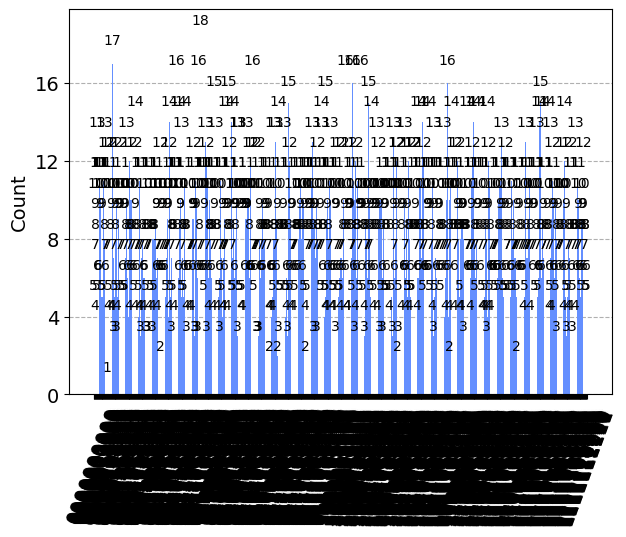

In [31]:
plot_histogram(counts)

In [29]:
answer = alethiometer(statement="Nothing is real")

No Quantum Computers available with 104 qubits.
Using Quantum Computer Simulator
Your job is number 1 in the queue on qasm_simulator.  Please wait...
COMPLETED in 0.004278898239135742 seconds on qasm_simulator
The probable result was 1 with 50.18310546875% probability
Your statement 'Nothing is real' is False.


In [27]:
answer = alethiometer(statement="I am not real")

No Quantum Computers available with 89 qubits.
Using Quantum Computer Simulator
Your job is number 1 in the queue on qasm_simulator.  Please wait...
COMPLETED in 0.004380702972412109 seconds on qasm_simulator
The probable result was 1 with 50.96435546875% probability
Your statement 'I am not real' is False.


In [26]:
answer = alethiometer(statement="You are not real")

No Quantum Computers available with 110 qubits.
Using Quantum Computer Simulator
Your job is number 1 in the queue on qasm_simulator.  Please wait...
COMPLETED in 0.004324913024902344 seconds on qasm_simulator
The probable result was 0 with 50.13427734375% probability
Your statement 'You are not real' is True.


In [23]:
answer = alethiometer(statement="I should eat less chocolate")

No Quantum Computers available with 186 qubits.
Using Quantum Computer Simulator
Your job is number 1 in the queue on qasm_simulator.  Please wait...
COMPLETED in 0.0043184757232666016 seconds on qasm_simulator
The probable result was 1 with 50.18310546875% probability
Your statement 'I should eat less chocolate' is False.
